# Data Scientist Professional Practical Exam Submission

Tasty Bytes, an online search engine for recipes and meal plan subscription provider, has asked our data science team to help them predict which recipes, when posted to the site's home page, lead to high website traffic. 

According to the Product Manager of Recipe Discovery, traffic to other parts of the website can go up by as much as 40% if a popular recipe is picked, leading to more subscriptions and thus the success of the business.

We have been tasked with two main objectives: 
1) To predict which recipes will lead to high traffic, and 
2) To correctly predict high traffic recipes 80% of the time

In order to tackle these objectives, I will take the following steps:
- Data cleaning and validation
- Exploratory analysis with data visualization
- Pre-processing the data for modeling
- Model Fitting
- Model Evaluation

## Data Cleaning and Validation
It is important to validate all variables and clean the data to make it ready for further analysis. This includes checking for missing values, validating data types, and finding outliers. 

In [28]:
# Importing necessary libraries for data importing and validation
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np

# Reading in data and turning recipe number into index
recipes = pd.read_csv('recipe_site_traffic_2212.csv', index_col='recipe')

# Inspecting first five rows of data to make sure it was imported correctly
display(recipes.head())

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
recipe,,,,,,,
1,NaN,NaN,NaN,NaN,Pork,6,High
2,35.48,38.56,0.66,0.92,Potato,4,High
3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
4,97.03,30.56,38.63,0.02,Beverages,4,High
5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [29]:
# Find and count number of missing values by column, count total number of observations in the data set
display(recipes.isna().sum())
display(len(recipes))

calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64

947

We have 947 instances in this data set, with 52 missing values each in the calories, carbohydrate, sugar, and protein columns, and 373 missing values in the high_traffic column.

It's possible that the 52 missing values across calories, carbohydrates, sugar, and protein are for the same rows. In that case, those rows are not very useful because they contain too much missing data. I will try dropping any rows that have missing values for all four of these columns, and see if that takes care of the issue.

In [30]:
recipes.dropna(how='all', subset=['calories', 'carbohydrate', 'sugar', 'protein'], inplace=True)
display(recipes.isna().sum())
display(len(recipes))

calories          0
carbohydrate      0
sugar             0
protein           0
category          0
servings          0
high_traffic    360
dtype: int64

895

The dropna() function dropped 52 observations (947-895), and all of the 52 missing values for calories, carbohydrate, sugar, and protein columns disappeared, which is what we were hoping for. The high_traffic column has missing values for any recipes that did not get high traffic, so we will just need to convert those to boolean 0's. 

Let's take a look at the data types of the columns, and make sure that they align with the brief and allow us to do the proper analyses on them.

In [31]:
# Checking data types to make sure they match what was in the brief 
display(recipes.dtypes)

# Replace a servings values with just their numeric value to keep categories consistent
recipes['servings'] = recipes['servings'].replace('4 as a snack', '4')
recipes['servings'] = recipes['servings'].replace('6 as a snack', '6')

# Convert high_traffic to boolean type by filling null values with False, and replacing values equal to 'High' with True
recipes['high_traffic'] = recipes['high_traffic'].fillna(value=False)
recipes['high_traffic'] = recipes['high_traffic'].replace('High', True)
recipes['high_traffic'] = recipes['high_traffic'].astype('bool')

# Checking if category column matches the options given in the project brief
display(recipes['category'].value_counts())

# Replacing 'Chicken Breast' option with just 'Chicken'
recipes['category'] = recipes['category'].replace('Chicken Breast', 'Chicken')

# Convert category and servings columns to dummy variables, so we can use them later with sci-kit learn
category_dummies = pd.get_dummies(recipes['category'], drop_first = True)
servings_dummies = pd.get_dummies(recipes['servings'], drop_first = True)
recipes = pd.concat([recipes, category_dummies, servings_dummies], axis=1)
recipes = recipes.rename(columns = {'One Dish Meal': 'One_Dish_Meal', '2': '2_servings', '4': '4_servings', '6':'6_servings'})
display(recipes.dtypes)
display(recipes)

calories        float64
carbohydrate    float64
sugar           float64
protein         float64
category         object
servings         object
high_traffic     object
dtype: object

Breakfast         106
Chicken Breast     94
Beverages          92
Potato             83
Lunch/Snacks       82
Vegetable          78
Dessert            77
Meat               74
Pork               73
Chicken            69
One Dish Meal      67
Name: category, dtype: int64

calories         float64
carbohydrate     float64
sugar            float64
protein          float64
category          object
servings          object
high_traffic        bool
Breakfast          uint8
Chicken            uint8
Dessert            uint8
Lunch/Snacks       uint8
Meat               uint8
One_Dish_Meal      uint8
Pork               uint8
Potato             uint8
Vegetable          uint8
2_servings         uint8
4_servings         uint8
6_servings         uint8
dtype: object

,calories,carbohydrate,sugar,protein,category,servings,high_traffic,Breakfast,Chicken,Dessert,Lunch/Snacks,Meat,One_Dish_Meal,Pork,Potato,Vegetable,2_servings,4_servings,6_servings
recipe,,,,,,,,,,,,,,,,,,,
2,35.48,38.56,0.66,0.92,Potato,4,True,0,0,0,0,0,0,0,1,0,0,1,0
3,914.28,42.68,3.09,2.88,Breakfast,1,False,1,0,0,0,0,0,0,0,0,0,0,0
4,97.03,30.56,38.63,0.02,Beverages,4,True,0,0,0,0,0,0,0,0,0,0,1,0
5,27.05,1.85,0.80,0.53,Beverages,4,False,0,0,0,0,0,0,0,0,0,0,1,0
6,691.15,3.46,1.65,53.93,One Dish Meal,2,True,0,0,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942,186.21,83.94,1.98,22.40,Chicken,4,True,0,1,0,0,0,0,0,0,0,0,1,0
943,1161.00,5.31,22.39,44.22,Lunch/Snacks,2,False,0,0,0,1,0,0,0,0,0,1,0,0
945,951.74,29.42,3.57,13.87,Pork,2,True,0,0,0,0,0,0,1,0,0,1,0,0


So far, we have dealt with missing values and validated the data types of the columns. Now let's take a look at some summary statistics and visualizations for the data to try to identify outliers and any skewness. 

,calories,carbohydrate,sugar,protein,Breakfast,Chicken,Dessert,Lunch/Snacks,Meat,One_Dish_Meal,Pork,Potato,Vegetable,2_servings,4_servings,6_servings
count,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.00000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000
mean,435.939196,35.069676,9.046547,24.149296,0.118436,0.182123,0.086034,0.09162,0.082682,0.074860,0.081564,0.092737,0.087151,0.194413,0.410056,0.206704
std,453.020997,43.949032,14.679176,36.369739,0.323304,0.386162,0.280570,0.28865,0.275554,0.263313,0.273853,0.290226,0.282214,0.395970,0.492119,0.405168
min,0.140000,0.030000,0.010000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,110.430000,8.375000,1.690000,3.195000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,288.550000,21.480000,4.550000,10.800000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,597.650000,44.965000,9.800000,30.200000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,3633.160000,530.420000,148.750000,363.360000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


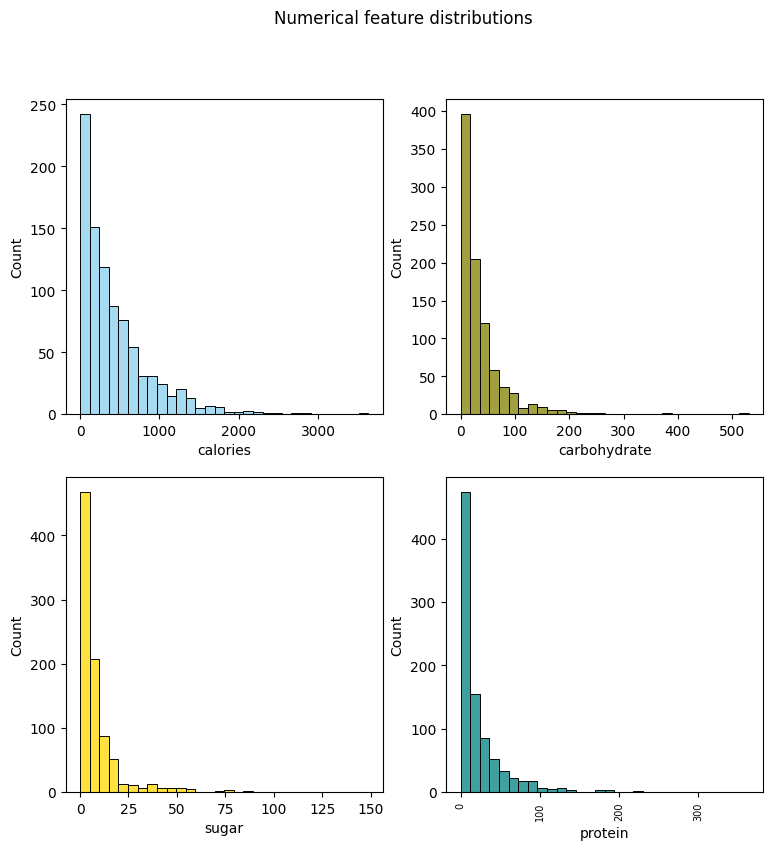

In [32]:
# Summary statistics for each column
display(recipes.describe())

# Visualizing the data column distributions using histograms
fig, axs = plt.subplots(2, 2, figsize=(9,9))
sns.histplot(data=recipes, x="calories", color="skyblue", ax=axs[0, 0], bins=30)
sns.histplot(data=recipes, x="carbohydrate", color="olive", ax=axs[0, 1], bins=30)
sns.histplot(data=recipes, x="sugar", color="gold", ax=axs[1, 0], bins=30)
sns.histplot(data=recipes, x="protein", color="teal", ax=axs[1, 1], bins=30)
plt.xticks(rotation=90,fontsize=7)
plt.suptitle('Numerical feature distributions')
plt.show()

The above plots give us a brief insight into the numeric variables. The calories, carbohydrate, sugar, and protein columns are all right-skewed, and there appear to be quite a number of outliers in the right tail. 

We see supporting information in the descriptive statistics. We can see that the minimum and maximum values of the calories column are nonsensical (0.14 and 3,633.16, respectively). We also see some nonsensical maximum values in the carbohydrate, sugar, and protein columns. For example, the maximum carbohydrate value is 530.42 grams. We know that carbohydrates contain 4 calories per gram, which would lead us to believe that this particular recipe contains at least 2,121.68 calories per serving. However, when we investigate this row of the data, it indicates that this recipe only contains 182.76 calories per serving.

It is likely that these errors are the result of misplaced decimal points. In the above example, the recipe with 530.42 grams of carbohydrates may actually only have 5.3 grams. Because we don't have the ability to communicate with the product manager to talk about how this data was sourced and whether there may be any human or non-human error involved, I will choose to drop observations with outliers in order to maintain the integrity of the dataset. 

In order to identify the outliers, I will transform the data so we can more easily identify outliers in both the left and right tails. Eliminating skewness in data is also beneficial for machine learning because skewness can degrade a model's ability to predict in the less populated areas of the distribution.

I will try a few transformations below to get these columns to look more like normal distributions, before identifying outliers using the IQR method.

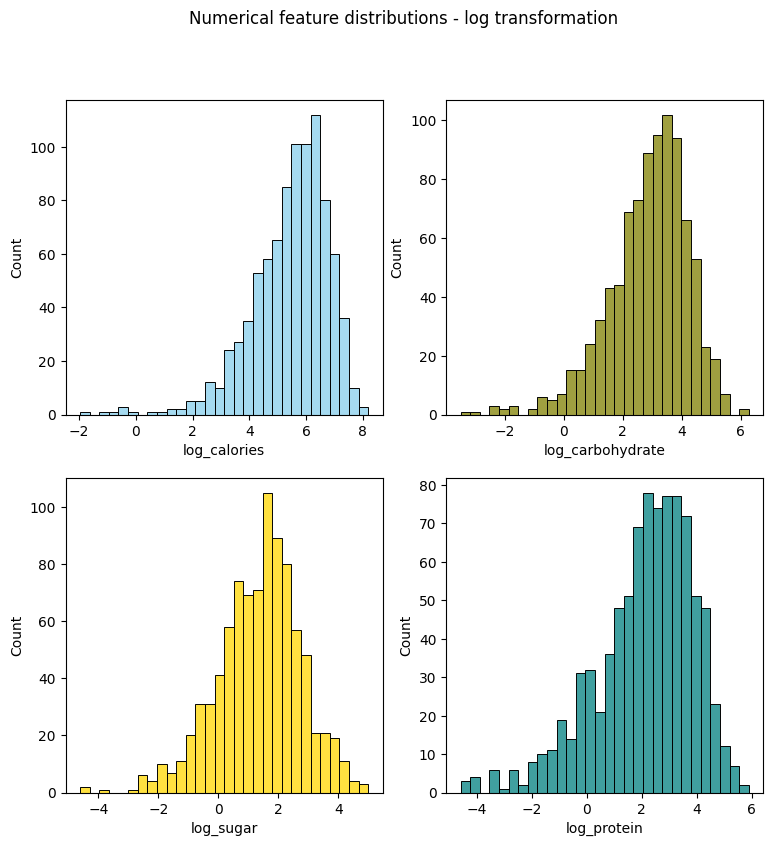

In [33]:
# Trying a log transformation on the data and re-plotting distribution
recipes['log_calories'] = np.log(recipes['calories'])
recipes['log_carbohydrate'] = np.log(recipes['carbohydrate'])
recipes['log_sugar'] = np.log(recipes['sugar'])
recipes['log_protein'] = np.log(recipes['protein'])

fig, axs = plt.subplots(2, 2, figsize=(9,9))
sns.histplot(data=recipes, x="log_calories", color="skyblue", ax=axs[0, 0], bins=30)
sns.histplot(data=recipes, x="log_carbohydrate", color="olive", ax=axs[0, 1], bins=30)
sns.histplot(data=recipes, x="log_sugar", color="gold", ax=axs[1, 0], bins=30)
sns.histplot(data=recipes, x="log_protein", color="teal", ax=axs[1, 1], bins=30)
plt.suptitle('Numerical feature distributions - log transformation')
plt.show()

These distributions are looking more normal, but it looks like the log transformation moved the distributions a little too far to the right and now they are left skewed, which makes it hard to eliminate outliers in the right tail. I will try a few other transformations below.

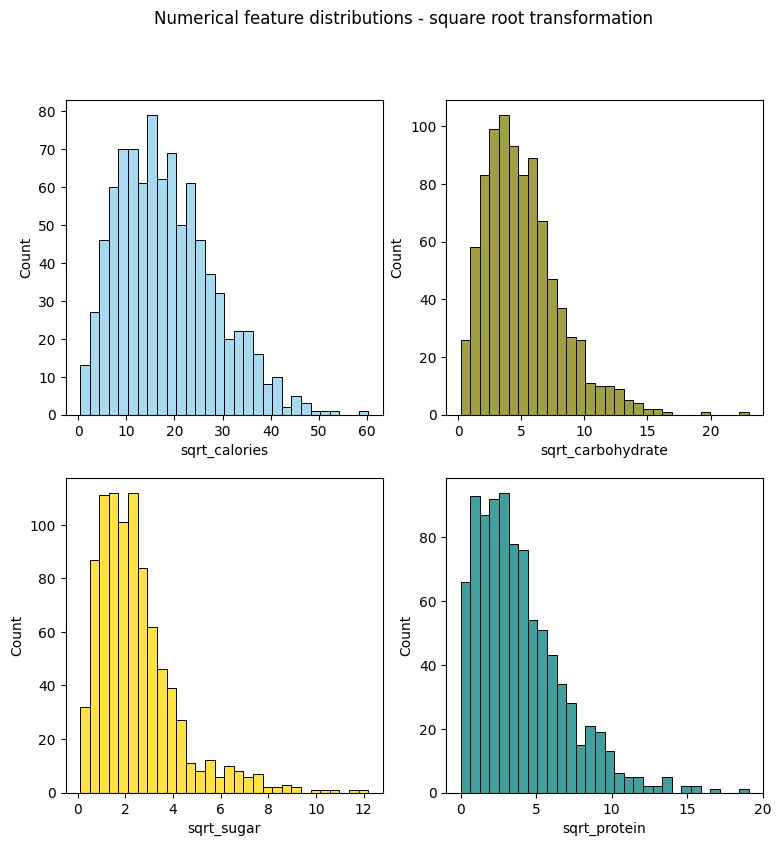

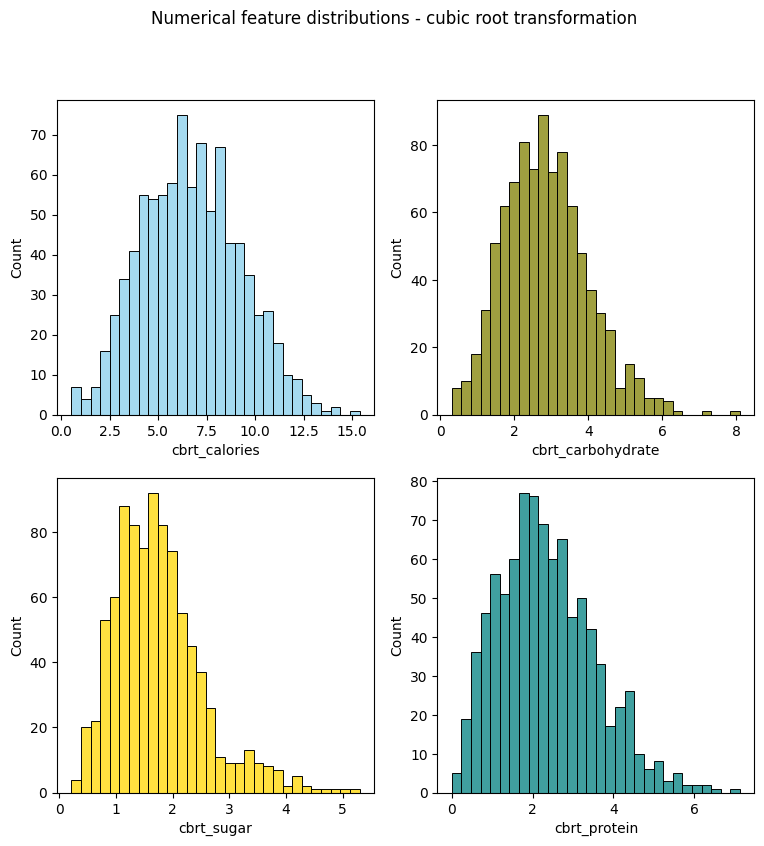

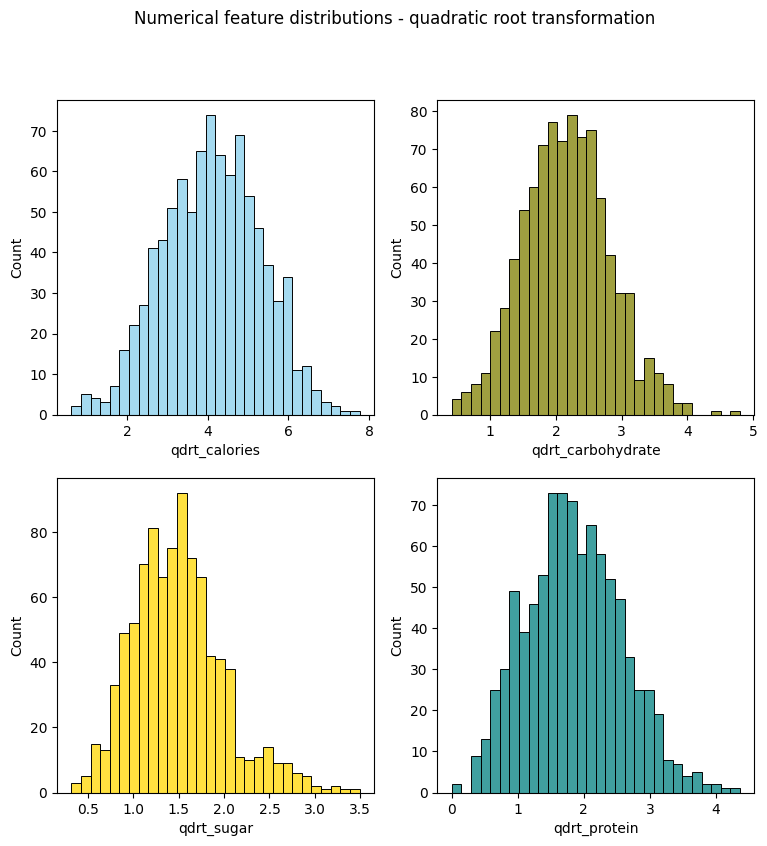

In [34]:
# Trying a square root transformation on the data and re-plotting distribution
recipes['sqrt_calories'] = np.sqrt(recipes['calories'])
recipes['sqrt_carbohydrate'] = np.sqrt(recipes['carbohydrate'])
recipes['sqrt_sugar'] = np.sqrt(recipes['sugar'])
recipes['sqrt_protein'] = np.sqrt(recipes['protein'])

fig, axs = plt.subplots(2, 2, figsize=(9,9))
sns.histplot(data=recipes, x="sqrt_calories", color="skyblue", ax=axs[0, 0], bins=30)
sns.histplot(data=recipes, x="sqrt_carbohydrate", color="olive", ax=axs[0, 1], bins=30)
sns.histplot(data=recipes, x="sqrt_sugar", color="gold", ax=axs[1, 0], bins=30)
sns.histplot(data=recipes, x="sqrt_protein", color="teal", ax=axs[1, 1], bins=30)
plt.suptitle('Numerical feature distributions - square root transformation')
plt.show()

# Trying a cubic root transformation on the data and re-plotting distribution
recipes['cbrt_calories'] = np.cbrt(recipes['calories'])
recipes['cbrt_carbohydrate'] = np.cbrt(recipes['carbohydrate'])
recipes['cbrt_sugar'] = np.cbrt(recipes['sugar'])
recipes['cbrt_protein'] = np.cbrt(recipes['protein'])

fig, axs = plt.subplots(2, 2, figsize=(9,9))
sns.histplot(data=recipes, x="cbrt_calories", color="skyblue", ax=axs[0, 0], bins=30)
sns.histplot(data=recipes, x="cbrt_carbohydrate", color="olive", ax=axs[0, 1], bins=30)
sns.histplot(data=recipes, x="cbrt_sugar", color="gold", ax=axs[1, 0], bins=30)
sns.histplot(data=recipes, x="cbrt_protein", color="teal", ax=axs[1, 1], bins=30)
plt.suptitle('Numerical feature distributions - cubic root transformation')
plt.show()

# Trying a quadratic root transformation on the data and re-plotting distribution
recipes['qdrt_calories'] = np.power(recipes['calories'], 1/4)
recipes['qdrt_carbohydrate'] = np.power(recipes['carbohydrate'], 1/4)
recipes['qdrt_sugar'] = np.power(recipes['sugar'], 1/4)
recipes['qdrt_protein'] = np.power(recipes['protein'], 1/4)

fig, axs = plt.subplots(2, 2, figsize=(9,9))
sns.histplot(data=recipes, x="qdrt_calories", color="skyblue", ax=axs[0, 0], bins=30)
sns.histplot(data=recipes, x="qdrt_carbohydrate", color="olive", ax=axs[0, 1], bins=30)
sns.histplot(data=recipes, x="qdrt_sugar", color="gold", ax=axs[1, 0], bins=30)
sns.histplot(data=recipes, x="qdrt_protein", color="teal", ax=axs[1, 1], bins=30)
plt.suptitle('Numerical feature distributions - quadratic root transformation')
plt.show()


I like the quadratic root transformation here as it spreads out the lower values while still maintaining the right tail as well, which will allow us to identify outliers in both tails. I will go ahead and find the outliers for each column by the recipe category. The reason I decided to sort by category as well is because different types of recipes have different nutritional content. For example, we would expect a dessert recipe to have much more sugar than a vegetable recipe, so 35 grams of sugar may be an outlier for a vegetable recipe, but perfectly normal for a dessert recipe. Similarly, 0 grams of protein might be an outlier for a meat recipe, but within reason for a beverage recipe. I wanted to be able to identify outliers while taking into account the nuances between categories and their different nutritional contents. 

In [35]:
# Initializing empty lists to store our IQR and outlier data
columns = ['qdrt_calories', 'qdrt_carbohydrate', 'qdrt_sugar', 'qdrt_protein']
total_outliers = pd.DataFrame()
columns_Q1 = []
columns_Q3 = []
columns_IQR = []
columns_lower_range = []
columns_upper_range = []

# Identify outliers in each column using IQR method
for column in columns: 
    # Group by category and calculate quartiles and IQR
    category_Q1 = recipes.groupby('category')[column].quantile(0.25)
    category_Q3 = recipes.groupby('category')[column].quantile(0.75)
    category_IQR = category_Q3 - category_Q1
    
    # Calculate lower and upper bounds for each category
    category_lower_range = category_Q1 - (1.5 * category_IQR)
    category_upper_range = category_Q3 + (1.5 * category_IQR)
    
    # Identify outliers in each category and add them to the total_outliers DataFrame
    for category in recipes['category'].unique():
        category_outliers = recipes[(recipes['category'] == category) & ((recipes[column] < category_lower_range[category]) | (recipes[column] > category_upper_range[category]))]
        total_outliers = pd.concat([total_outliers, category_outliers])
    
    # Append quartiles, IQR, and bounds for the column to the corresponding lists
    columns_Q1.append(category_Q1)
    columns_Q3.append(category_Q3)
    columns_IQR.append(category_IQR)
    columns_lower_range.append(category_lower_range)
    columns_upper_range.append(category_upper_range)

# Creating a dataframe containing the stats generated in the for loop
stats = pd.DataFrame({'Q1': columns_Q1, 'Q3': columns_Q3, 'IQR': columns_IQR, 'lower_range': columns_lower_range, 'upper_range': columns_upper_range}, index=columns)
print('IQR statistics by column and category:')
display(stats)

# Display table of instances containing outliers
total_outliers.drop_duplicates(inplace=True)
print('Outliers:')
display(total_outliers.sort_values('qdrt_calories'))

# Because the above outliers only encompass around 2.9% of the dataset, I will just drop them
recipes = recipes.drop(total_outliers.index)


IQR statistics by column and category:


,Q1,Q3,IQR,lower_range,upper_range
qdrt_calories,category Beverages 2.824448 Breakfast ...,category Beverages 4.050229 Breakfast ...,category Beverages 1.225781 Breakfast ...,category Beverages 0.985776 Breakfast ...,category Beverages 5.888900 Breakfast ...
qdrt_carbohydrate,category Beverages 1.363364 Breakfast ...,category Beverages 2.141093 Breakfast ...,category Beverages 0.777729 Breakfast ...,category Beverages 0.196770 Breakfast ...,category Beverages 3.307686 Breakfast ...
qdrt_sugar,category Beverages 1.329799 Breakfast ...,category Beverages 1.998623 Breakfast ...,category Beverages 0.668824 Breakfast ...,category Beverages 0.326563 Breakfast ...,category Beverages 3.001859 Breakfast ...
qdrt_protein,category Beverages 0.619672 Breakfast ...,category Beverages 0.972640 Breakfast ...,category Beverages 0.352967 Breakfast ...,category Beverages 0.090222 Breakfast ...,category Beverages 1.502090 Breakfast ...


Outliers:


,calories,carbohydrate,sugar,protein,category,servings,high_traffic,Breakfast,Chicken,Dessert,Lunch/Snacks,Meat,One_Dish_Meal,Pork,Potato,Vegetable,2_servings,4_servings,6_servings,log_calories,log_carbohydrate,log_sugar,log_protein,sqrt_calories,sqrt_carbohydrate,sqrt_sugar,sqrt_protein,cbrt_calories,cbrt_carbohydrate,cbrt_sugar,cbrt_protein,qdrt_calories,qdrt_carbohydrate,qdrt_sugar,qdrt_protein
recipe,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
501,0.30,5.19,0.96,1.51,Beverages,4,False,0,0,0,0,0,0,0,0,0,0,1,0,-1.203973,1.646734,-0.040822,0.412110,0.547723,2.278157,0.979796,1.228821,0.669433,1.731367,0.986485,1.147252,0.740083,1.509357,0.989846,1.108522
653,0.54,30.59,10.45,0.36,Beverages,6,True,0,0,0,0,0,0,0,0,0,0,0,1,-0.616186,3.420673,2.346602,-1.021651,0.734847,5.530823,3.232646,0.600000,0.814325,3.127470,2.186278,0.711379,0.857232,2.351770,1.797956,0.774597
670,0.80,12.26,1.33,6.21,Chicken,6,False,0,1,0,0,0,0,0,0,0,0,0,1,-0.223144,2.506342,0.285179,1.826161,0.894427,3.501428,1.153256,2.491987,0.928318,2.305845,1.099724,1.838078,0.945742,1.871210,1.073898,1.578603
514,2.98,9.81,28.58,19.11,Chicken,1,False,0,1,0,0,0,0,0,0,0,0,0,0,1.091923,2.283402,3.352707,2.950212,1.726268,3.132092,5.346027,4.371499,1.439037,2.140703,3.057413,2.673541,1.313875,1.769772,2.312148,2.090813
469,27.11,22.63,4.93,0.00,Beverages,1,False,0,0,0,0,0,0,0,0,0,0,0,0,3.299903,3.119276,1.595339,-inf,5.206726,4.757100,2.220360,0.000000,3.004069,2.828535,1.701959,0.000000,2.281825,2.181078,1.490087,0.000000
591,52.08,75.39,49.53,28.37,Pork,6,True,0,0,0,0,0,0,1,0,0,0,0,1,3.952781,4.322675,3.902579,3.345332,7.216647,8.682742,7.037755,5.326350,3.734424,4.224460,3.672452,3.049906,2.686382,2.946649,2.652877,2.307889
848,88.17,49.37,0.01,0.40,Beverages,6,False,0,0,0,0,0,0,0,0,0,0,0,1,4.479267,3.899343,-4.605170,-0.916291,9.389888,7.026379,0.100000,0.632456,4.450823,3.668493,0.215443,0.736806,3.064292,2.650732,0.316228,0.795271
350,94.27,383.06,5.98,39.61,Potato,1,True,0,0,0,0,0,0,0,1,0,0,0,0,4.546163,5.948192,1.788421,3.679082,9.709274,19.571919,2.445404,6.293648,4.551185,7.262547,1.815099,3.408801,3.115971,4.424016,1.563779,2.508714
71,100.00,95.89,10.20,114.60,Lunch/Snacks,4,False,0,0,0,1,0,0,0,0,0,0,1,0,4.605170,4.563202,2.322388,4.741448,10.000000,9.792344,3.193744,10.705139,4.641589,4.577107,2.168703,4.857299,3.162278,3.129272,1.787105,3.271871


There are still recipes remaining in the dataset with less than 50 calories per serving or more than 1500 calories per serving, which are unrealistic unless in very specific circumstances. For example, we can imagine a recipe for a beverage like tea or coffee might contain less than 50 calories, but would not expect a recipe for Chicken or Pork to contain less than 50 calories per serving. Relying on domain knowledge/common sense can make sense in instances where a more methodical approach misses obvious erroneous instances. In this case, I will go ahead and drop observations with less than 50 calories per serving, unless they are in the Beverages, Vegetable, or Breakfast categories, which are the three categories with the lowest mean calories per serving. I will also drop observations with more than 1500 calories per serving. The below will drop an additional 80 observations, for a total of 106 observations dropped, or around 11.8% of the dataset. 

In [36]:
# Mean calories per serving, grouped by category
print('Descriptive statistics by category:')
display(recipes.groupby('category')['calories'].describe())

# Drop observations with less than 50 calories per serving, unless it is a Beverage, Vegetable, or a Breakfast 
recipes_cleaned = recipes[(recipes['calories'] > 50) | (recipes['category'].isin(['Beverages', 'Breakfast', 'Vegetable']))]
# Drop all observations with more than 1500 calories per serving 
recipes_cleaned = recipes_cleaned[recipes_cleaned['calories'] < 1500]

print('Finalized cleaned dataset:')
display(recipes_cleaned)

Descriptive statistics by category:


,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
Beverages,88.0,184.491364,161.394596,2.14,68.8925,135.375,274.2650,836.95
Breakfast,104.0,328.538173,341.347261,0.64,61.9200,216.030,494.5850,1724.25
Chicken,158.0,536.621646,485.319716,22.02,208.7125,377.240,659.7950,2508.47
Dessert,75.0,345.299867,302.197974,0.59,102.2900,267.510,536.5550,1588.26
Lunch/Snacks,80.0,488.181000,408.730688,0.14,124.3800,372.595,755.0850,1542.53
Meat,73.0,583.639315,502.670911,5.87,169.8300,454.270,816.2500,1706.75
One Dish Meal,67.0,579.090000,540.991509,13.62,186.8100,419.280,832.8600,2332.32
Pork,72.0,637.730694,625.114834,1.56,159.7150,405.210,957.4575,2906.01
Potato,75.0,418.001333,375.252006,9.26,137.0450,269.460,611.0000,2068.07


Finalized cleaned dataset:


,calories,carbohydrate,sugar,protein,category,servings,high_traffic,Breakfast,Chicken,Dessert,Lunch/Snacks,Meat,One_Dish_Meal,Pork,Potato,Vegetable,2_servings,4_servings,6_servings,log_calories,log_carbohydrate,log_sugar,log_protein,sqrt_calories,sqrt_carbohydrate,sqrt_sugar,sqrt_protein,cbrt_calories,cbrt_carbohydrate,cbrt_sugar,cbrt_protein,qdrt_calories,qdrt_carbohydrate,qdrt_sugar,qdrt_protein
recipe,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,914.28,42.68,3.09,2.88,Breakfast,1,False,1,0,0,0,0,0,0,0,0,0,0,0,6.818137,3.753730,1.128171,1.057790,30.237063,6.532993,1.757840,1.697056,9.705690,3.494686,1.456530,1.422757,5.498824,2.555972,1.325835,1.302711
4,97.03,30.56,38.63,0.02,Beverages,4,True,0,0,0,0,0,0,0,0,0,0,1,0,4.575020,3.419692,3.654029,-3.912023,9.850381,5.528110,6.215304,0.141421,4.595175,3.126447,3.380453,0.271442,3.138532,2.351193,2.493051,0.376060
5,27.05,1.85,0.80,0.53,Beverages,4,False,0,0,0,0,0,0,0,0,0,0,1,0,3.297687,0.615186,-0.223144,-0.634878,5.200961,1.360147,0.894427,0.728011,3.001851,1.227601,0.928318,0.809267,2.280562,1.166253,0.945742,0.853236
6,691.15,3.46,1.65,53.93,One Dish Meal,2,True,0,0,0,0,0,1,0,0,0,1,0,0,6.538357,1.241269,0.500775,3.987687,26.289732,1.860108,1.284523,7.343705,8.841462,1.512488,1.181666,3.778129,5.127351,1.363858,1.133368,2.709927
7,183.94,47.95,9.75,46.71,Chicken,4,False,0,1,0,0,0,0,0,0,0,0,1,0,5.214610,3.870159,2.277267,3.843958,13.562448,6.924594,3.122499,6.834471,5.687116,3.632979,2.136329,3.601388,3.682723,2.631462,1.767059,2.614282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942,186.21,83.94,1.98,22.40,Chicken,4,True,0,1,0,0,0,0,0,0,0,0,1,0,5.226875,4.430102,0.683097,3.109061,13.645878,9.161878,1.407125,4.732864,5.710415,4.378476,1.255707,2.818919,3.694033,3.026859,1.186223,2.175515
943,1161.00,5.31,22.39,44.22,Lunch/Snacks,2,False,0,0,0,1,0,0,0,0,0,1,0,0,7.057037,1.669592,3.108614,3.789177,34.073450,2.304344,4.731807,6.649812,10.510194,1.744609,2.818500,3.536222,5.837247,1.518006,2.175272,2.578723
945,951.74,29.42,3.57,13.87,Pork,2,True,0,0,0,0,0,0,1,0,0,1,0,0,6.858292,3.381675,1.272566,2.629728,30.850284,5.424021,1.889444,3.724245,9.836474,3.087078,1.528350,2.402659,5.554303,2.328953,1.374571,1.929830
